Below takes pcr swap probabilities and gapfill error probabilities for predefined feature set and returns cell genotypes with probabilities.
This should be pretty generic but may need adjustment if there are multiple possible alleles for the same probe

In [1]:
import sys
from gapfill_utilities import utils as gf_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
# sys.path.append('/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/src/')
# import utils as lm_utils
import scanpy as sc



In [2]:
# Parameters cell (must be tagged as "parameters")
lib = '2'


In [3]:
## these are now in lm_utils but there is an error
def get_p(allele1,allele2,fracs_1,sub_probe_reads):
    prob_columns = []
    for frac_1 in fracs_1:
        frac_2 = 1 - frac_1
        sub_probe_reads[allele1] = sub_probe_reads['p_' + allele1] * frac_1
        sub_probe_reads[allele2] = sub_probe_reads['p_' + allele2] * frac_2
        col_name = 'p_' + allele1 + '_' + allele2 + '_' + str(frac_1) + '_' + str(frac_2)
        sub_probe_reads[col_name] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].max(axis=1)
        prob_columns.append(col_name)
        allele_call_col = col_name.replace('p_','') + '_n_allele_1'
        sub_probe_reads[allele_call_col] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].idxmax(axis=1)
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == 'pcr_swap_likelihood',allele_call_col] = None
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele2,allele_call_col] = 0
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele1,allele_call_col] = 1
        sub_probe_reads.drop(columns=[allele1, allele2], inplace=True)
    return sub_probe_reads, prob_columns

def update_het_frac(sub_probe_reads, prob_columns):
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    het_cols = cell_genotypes.columns[~(cell_genotypes.columns.str.contains('0_1') | cell_genotypes.columns.str.contains('1_0'))]
    het_cells = cell_genotypes.loc[cell_genotypes[het_cols].sum(axis=1) > 0.8].index.get_level_values('barcode').unique()
    if len(het_cells) > 20:
        cols = sub_probe_reads.columns[(sub_probe_reads.columns.str.contains('n_allele_1')) & ~(sub_probe_reads.columns.str.contains('0_1')) & ~(sub_probe_reads.columns.str.contains('1_0'))]
        updated_frac1 = sub_probe_reads.loc[sub_probe_reads['barcode'].isin(het_cells)].groupby(['cell_idx','barcode'])[cols].mean().mean().mean()
        return updated_frac1
    else:
        return 0.5

def rename_genotype_columns(cell_genotypes, genotype_names):
    for col in cell_genotypes.columns:
        if col.endswith('0_1'):
            call = col.split('_')[2]
            if ((genotype_names['gapfill_value']) == call).sum() > 0:
                variant_name = genotype_names.loc[genotype_names['gapfill_value'] == call]['name'].values[0]
                variant_type = genotype_names.loc[genotype_names['gapfill_value'] == call]['variant'].map({False : '_wt', True : '_mutated'}).values[0]
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
        elif col.endswith('1_0'):
            call = col.split('_')[1]
            if ((genotype_names['gapfill_value']) == call).sum() > 0:
                variant_name = genotype_names.loc[genotype_names['gapfill_value'] == call]['name'].values[0]
                variant_type = genotype_names.loc[genotype_names['gapfill_value'] == call]['variant'].map({False : '_wt', True : '_mutated'}).values[0]
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
        else:
            call1 = col.split('_')[1]
            call2 = col.split('_')[2]
            if (((genotype_names['gapfill_value']) == call1).sum() > 0) & (((genotype_names['gapfill_value']) == call2).sum() > 0):
                variants = genotype_names.loc[(genotype_names['gapfill_value'] == call1) | (genotype_names['gapfill_value'] == call2)]
                variant_name = variants.loc[variants['variant'] == True]['name'].values[0]
                variant_type = '_heterozygous'
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
    return cell_genotypes

def get_cell_genotypes(probe_idx,probe_reads,genotype_names,fracs_1 = [0,0.5,1], learn_het_frac = True):
    sub_probe_reads = probe_reads.loc[probe_reads['probe_idx'] == probe_idx]
    sub_probe_reads = sub_probe_reads.dropna(axis=1, how='all')
    possible_alleles = sub_probe_reads.columns[sub_probe_reads.columns.str.contains('p_gapfill_given_')]
    sub_probe_reads[possible_alleles.str.replace('_gapfill_given','')] = sub_probe_reads[possible_alleles].div(sub_probe_reads[possible_alleles].sum(axis=1), axis=0)
    sub_probe_reads = sub_probe_reads.drop(columns=possible_alleles)
    possible_alleles = possible_alleles.str.replace('p_gapfill_given_','')
    for allele_combination in list(combinations(possible_alleles, 2)):
        allele1 = allele_combination[0]
        allele2 = allele_combination[1]
        sub_probe_reads, prob_columns = get_p(allele1, allele2, fracs_1, sub_probe_reads)
        if learn_het_frac:
            updated_het_frac = np.round(update_het_frac(sub_probe_reads, prob_columns),2)
            sub_probe_reads, prob_columns = get_p(allele1, allele2, [0,updated_het_frac,1], sub_probe_reads)
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    cell_genotypes = rename_genotype_columns(cell_genotypes, genotype_names)
    cell_genotypes = cell_genotypes.reset_index()
    probe_name = cell_genotypes.columns[cell_genotypes.columns.str.contains('_mutated')].str.replace('_mutated','')[0]
    cell_genotypes[probe_name + '_high_confidence_counts'] = cell_genotypes['barcode'].map(sub_probe_reads.loc[sub_probe_reads['pcr_swap_likelihood'] < 0.1]['barcode'].value_counts().to_dict()).fillna(0)
    return cell_genotypes

Processing BC: BC001


455940 UMIs found


Collapsing UMIs across probes, 455940 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 454379 UMIs remaining (99.66%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 454178 UMIs remaining (99.61%)


587745 UMIs found


Collapsing UMIs across probes, 587745 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 586075 UMIs remaining (99.72%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 583402 UMIs remaining (99.26%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


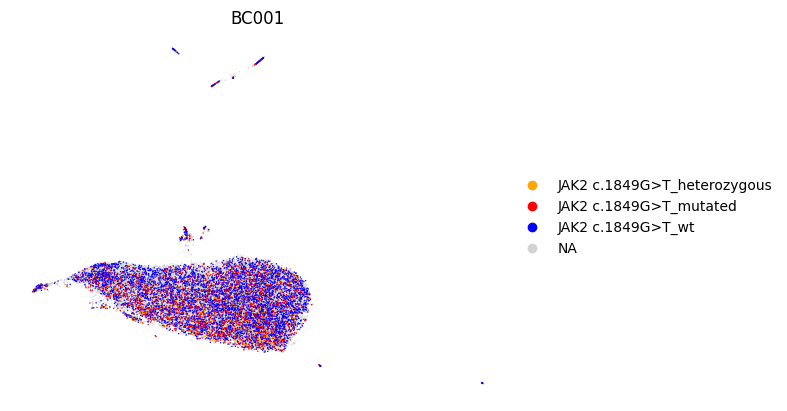

Processing BC: BC002
115394 UMIs found
Collapsing UMIs across probes, 115394 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 115015 UMIs remaining (99.67%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 114456 UMIs remaining (99.19%)
145240 UMIs found


Collapsing UMIs across probes, 145240 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 144879 UMIs remaining (99.75%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 121362 UMIs remaining (83.56%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


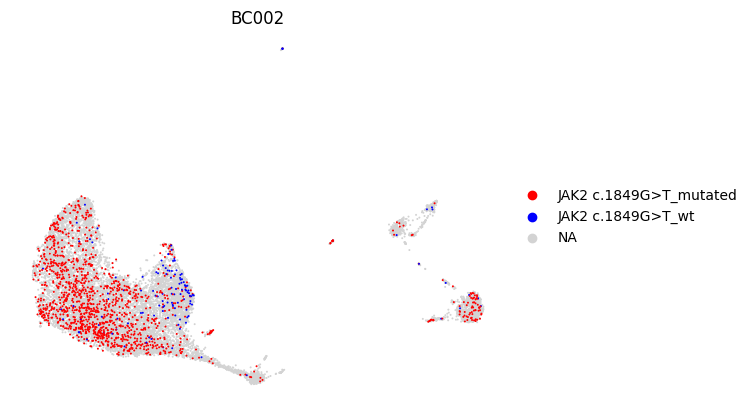

Processing BC: BC003
38761 UMIs found
Collapsing UMIs across probes, 38761 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 38617 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 38465 UMIs remaining (99.24%)
53546 UMIs found
Collapsing UMIs across probes, 53546 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 53391 UMIs remaining (99.71%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 53049 UMIs remaining (99.07%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


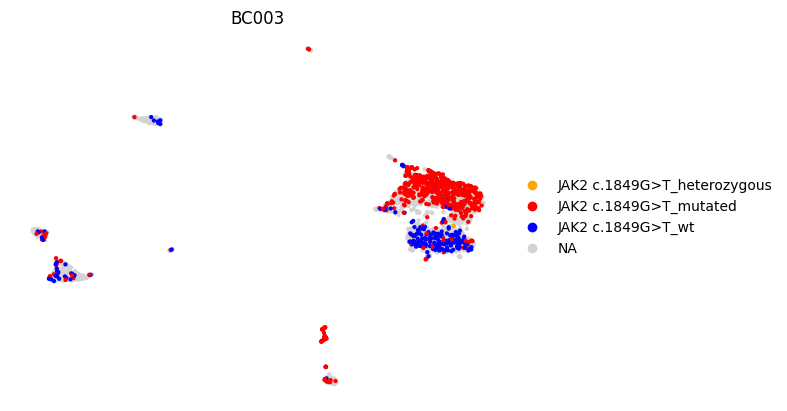

Processing BC: BC004


353446 UMIs found
Collapsing UMIs across probes, 353446 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 352206 UMIs remaining (99.65%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 349922 UMIs remaining (99.00%)


482959 UMIs found


Collapsing UMIs across probes, 482959 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 481617 UMIs remaining (99.72%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 468882 UMIs remaining (97.09%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


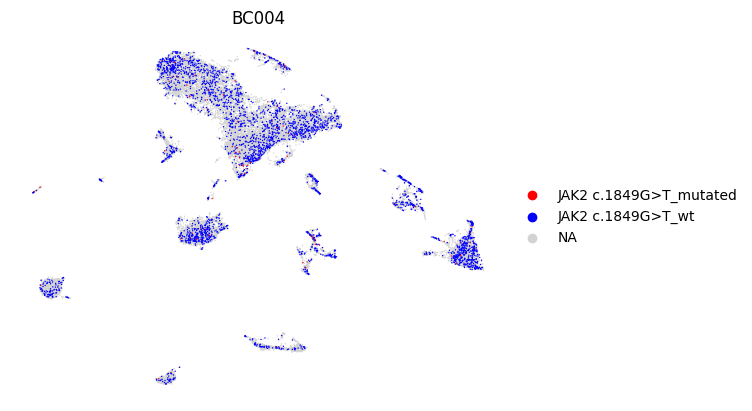

Processing BC: BC005


1170446 UMIs found


Collapsing UMIs across probes, 1170446 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1166004 UMIs remaining (99.62%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1159525 UMIs remaining (99.07%)


1166210 UMIs found


Collapsing UMIs across probes, 1166210 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1162784 UMIs remaining (99.71%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1147898 UMIs remaining (98.43%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


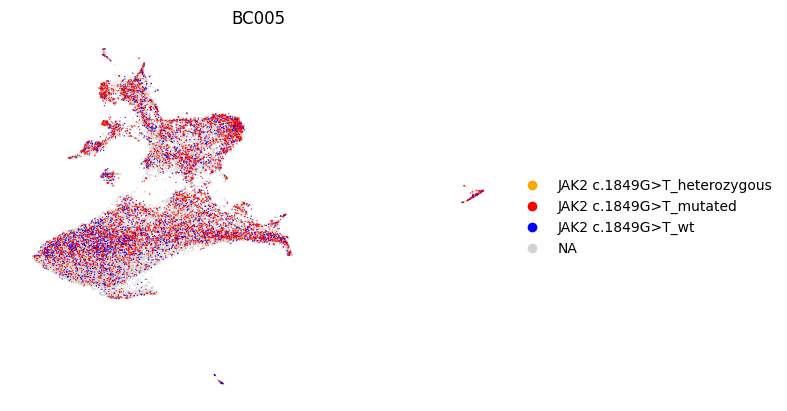

Processing BC: BC006


1154939 UMIs found


Collapsing UMIs across probes, 1154939 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1150414 UMIs remaining (99.61%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1147145 UMIs remaining (99.33%)


1131641 UMIs found


Collapsing UMIs across probes, 1131641 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1128366 UMIs remaining (99.71%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1115101 UMIs remaining (98.54%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


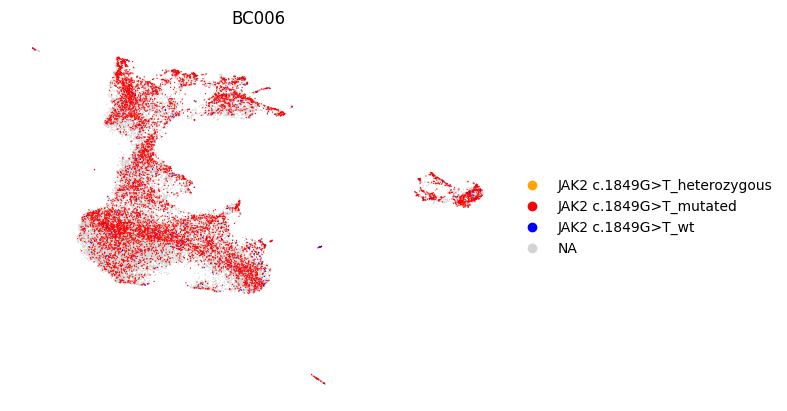

Processing BC: BC007
104353 UMIs found
Collapsing UMIs across probes, 104353 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 103998 UMIs remaining (99.66%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 94232 UMIs remaining (90.30%)
132658 UMIs found
Collapsing UMIs across probes, 132658 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 132336 UMIs remaining (99.76%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 122885 UMIs remaining (92.63%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


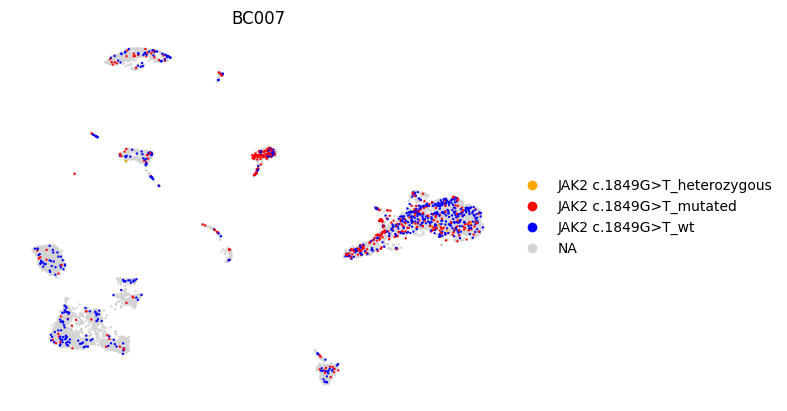

Processing BC: BC008
93523 UMIs found
Collapsing UMIs across probes, 93523 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 93165 UMIs remaining (99.62%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 92716 UMIs remaining (99.14%)
141999 UMIs found
Collapsing UMIs across probes, 141999 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 141627 UMIs remaining (99.74%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 137261 UMIs remaining (96.66%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


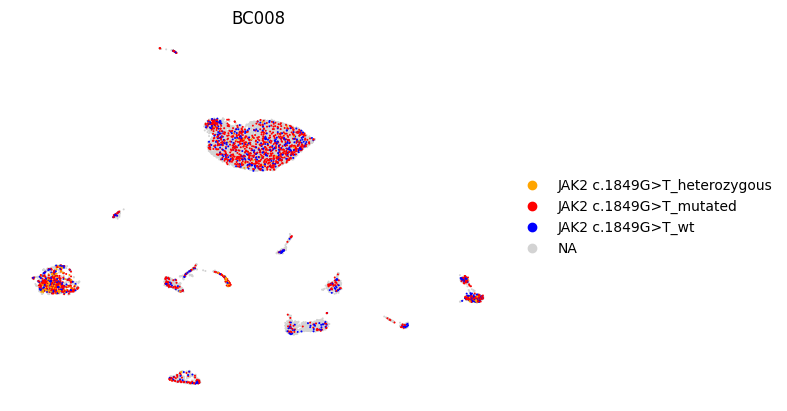

Processing BC: BC009
59872 UMIs found
Collapsing UMIs across probes, 59872 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 59669 UMIs remaining (99.66%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 52090 UMIs remaining (87.00%)
109965 UMIs found
Collapsing UMIs across probes, 109965 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 109655 UMIs remaining (99.72%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 94662 UMIs remaining (86.08%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


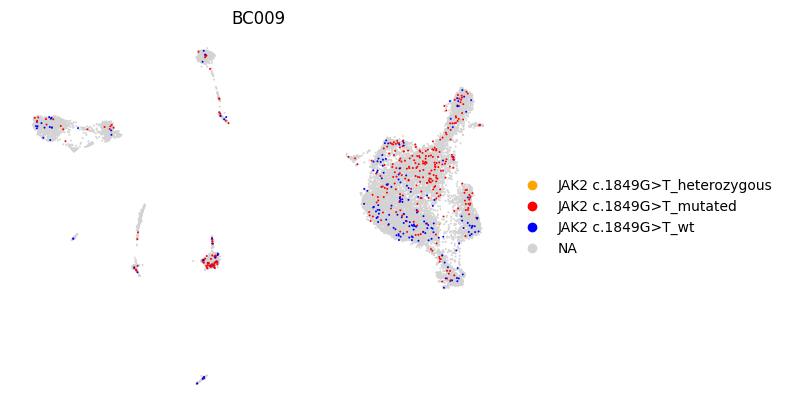

Processing BC: BC010
165877 UMIs found


Collapsing UMIs across probes, 165877 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 165261 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 127083 UMIs remaining (76.61%)
209341 UMIs found


Collapsing UMIs across probes, 209341 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 208749 UMIs remaining (99.72%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 177756 UMIs remaining (84.91%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


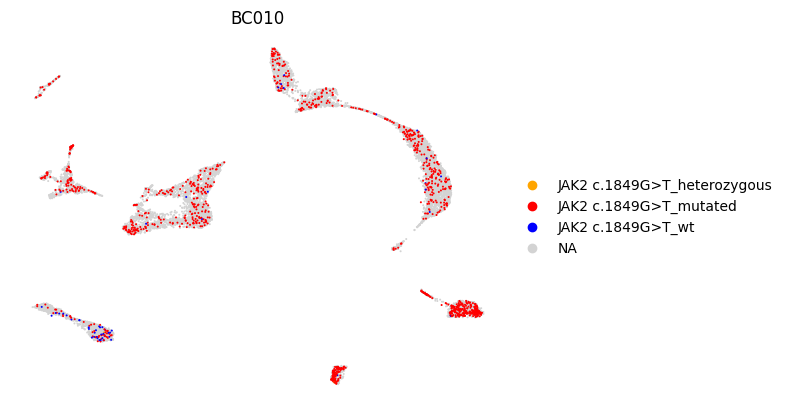

Processing BC: BC011


1685834 UMIs found


Collapsing UMIs across probes, 1685834 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1677744 UMIs remaining (99.52%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1412024 UMIs remaining (83.76%)


1603023 UMIs found


Collapsing UMIs across probes, 1603023 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1597109 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1477917 UMIs remaining (92.20%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


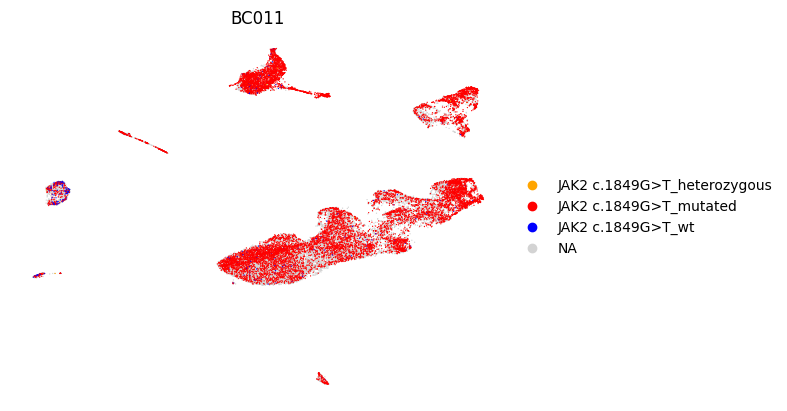

Processing BC: BC012


402426 UMIs found


Collapsing UMIs across probes, 402426 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 400782 UMIs remaining (99.59%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 356506 UMIs remaining (88.59%)


480812 UMIs found


Collapsing UMIs across probes, 480812 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 479242 UMIs remaining (99.67%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 441774 UMIs remaining (91.88%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


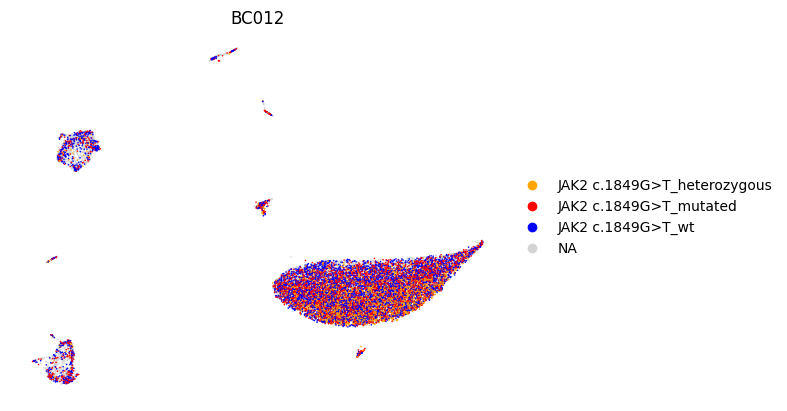

Processing BC: BC013


2108039 UMIs found


Collapsing UMIs across probes, 2108039 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2098022 UMIs remaining (99.52%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1705153 UMIs remaining (80.89%)


2082358 UMIs found


Collapsing UMIs across probes, 2082358 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2074373 UMIs remaining (99.62%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1919410 UMIs remaining (92.17%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


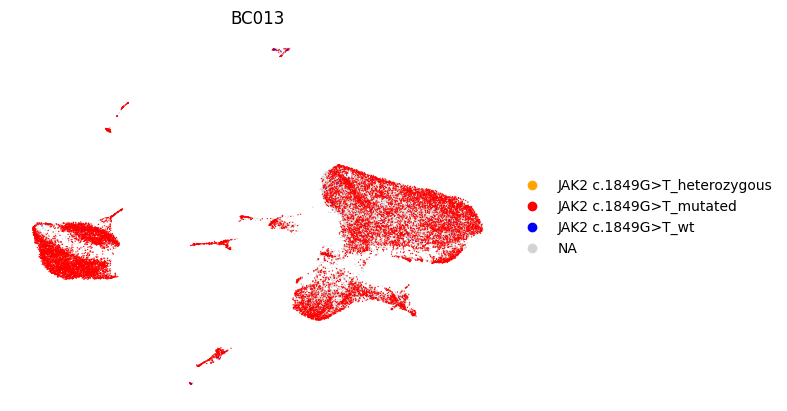

Processing BC: BC014
156687 UMIs found
Collapsing UMIs across probes, 156687 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 156108 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 139103 UMIs remaining (88.78%)


273539 UMIs found
Collapsing UMIs across probes, 273539 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 272799 UMIs remaining (99.73%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 254066 UMIs remaining (92.88%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


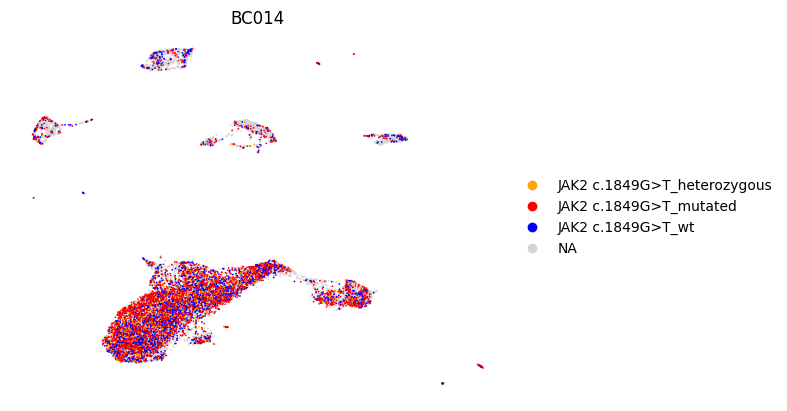

Processing BC: BC015


2246870 UMIs found


Collapsing UMIs across probes, 2246870 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2236718 UMIs remaining (99.55%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2230276 UMIs remaining (99.26%)


2207024 UMIs found


Collapsing UMIs across probes, 2207024 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2199227 UMIs remaining (99.65%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2181996 UMIs remaining (98.87%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


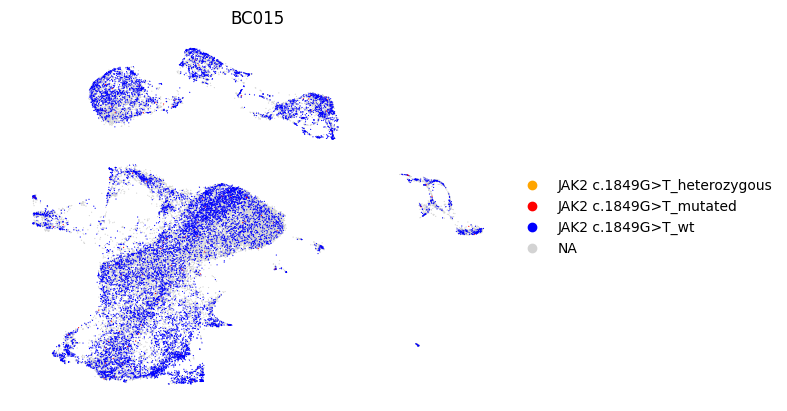

Processing BC: BC016


2102281 UMIs found


Collapsing UMIs across probes, 2102281 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2091280 UMIs remaining (99.48%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2090496 UMIs remaining (99.44%)


2095903 UMIs found


Collapsing UMIs across probes, 2095903 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2087422 UMIs remaining (99.60%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2076505 UMIs remaining (99.07%)


/tmp/ipykernel_2381060/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


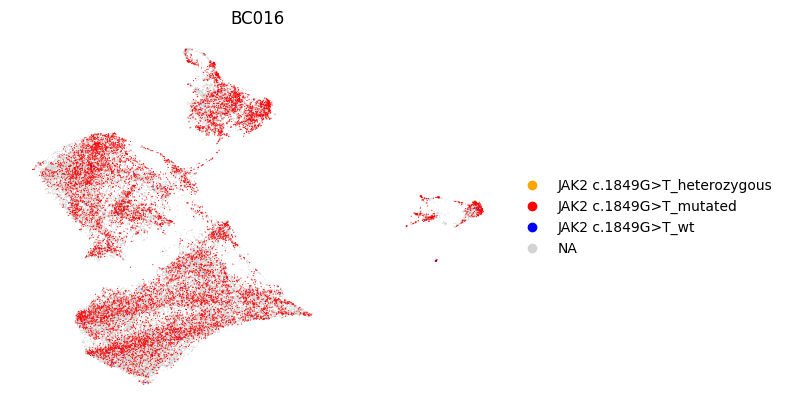

In [4]:
for BC in ['BC001', 'BC002', 'BC003', 'BC004', 'BC005', 'BC006', 'BC007', 'BC008', 'BC009', 'BC010', 'BC011', 'BC012', 'BC013', 'BC014', 'BC015', 'BC016']:
    print('Processing BC:', BC)
    adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250605_MPN_' + lib + '_' + BC + '.h5ad'
    gf_dirs = {}
    gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    min_percent_supporting = 0.9
    collapse_across_probes = True
    for key,gf_dir in gf_dirs.items():
        if key == 0:
            probe_reads = gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)
        else:
            probe_reads = pd.concat([probe_reads, gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)], ignore_index=True)

    gapfill_likelihoods = pd.read_csv('likelihood_tables/' + BC + '_gapfill_likelihoods.csv')
    columns_to_rename = gapfill_likelihoods.columns.difference(['probe_idx', 'gapfill'])
    gapfill_likelihoods.rename(columns={col: 'p_gapfill_given_' + col for col in columns_to_rename}, inplace=True)

    pcr_swap_likelihoods = pd.read_csv('likelihood_tables/patient_' + BC + '_swap_probabilities.csv')
    pcr_swap_likelihoods.rename(columns={'likelihood':'no_pcr_swap_likelihood'}, inplace=True)
    pcr_swap_likelihoods['pcr_swap_likelihood'] = 1 - pcr_swap_likelihoods['no_pcr_swap_likelihood']

    variant_probes = gapfill_likelihoods['probe_idx'].unique()
    probe_reads = probe_reads.loc[probe_reads['probe_idx'].isin(variant_probes)]
    probe_reads = probe_reads.merge(gapfill_likelihoods, how='left', on = ['probe_idx','gapfill'])
    probe_reads = probe_reads.merge(pcr_swap_likelihoods[['pcr_duplicate_count','pcr_swap_likelihood']], how='left', on = 'pcr_duplicate_count')
    probe_reads.drop(['umi','percent_supporting','probe_barcode'],axis=1, inplace=True)

    alt_genotypes = pd.read_csv('likelihood_tables/all_gapfill_features_filtered_combined.csv')
    manifest = gf_utils.get_manifest(gf_dirs[0])
    probe_name_to_probe_idx = dict(zip(manifest['name'], manifest['index']))
    alt_genotypes['probe_idx'] = alt_genotypes['name'].map(probe_name_to_probe_idx)

    alt_genotypes = pd.concat([
        alt_genotypes[['probe_idx', 'name', 'gapfill']].rename(columns={'gapfill': 'gapfill_value'}).assign(variant=True),
        alt_genotypes[['probe_idx', 'name', 'gapfill_from_transcriptome']].rename(columns={'gapfill_from_transcriptome': 'gapfill_value'}).assign(variant=False)
    ], ignore_index=True)

    cell_genotypes = {}
    for probe_idx in probe_reads['probe_idx'].unique():
        cell_genotypes[probe_idx] = get_cell_genotypes(probe_idx,probe_reads, alt_genotypes.loc[alt_genotypes['probe_idx'] == probe_idx], learn_het_frac = False)

    all_df = pd.DataFrame()
    for probe_idx in cell_genotypes.keys():
        df = cell_genotypes[probe_idx].set_index('barcode').drop(['cell_idx'],axis=1)
        all_df = all_df.merge(df, how='outer', left_index=True, right_index=True)

    adata = gf_utils.read_adata(adata_path)
    adata.obsm['genotypes'] = all_df.reindex(adata.obs_names)
    adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)
    sc.pl.umap(adata, color='genotype', frameon=False, palette={'JAK2 c.1849G>T_mutated':'red','JAK2 c.1849G>T_wt':'blue','JAK2 c.1849G>T_heterozygous':'orange'}, title = BC)
    adata.write(adata_path.replace('.h5ad','_genotyped.h5ad'))
